In [318]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import datetime

import nirs

In [319]:
# parameters

case_id = 7

cde_duration = 300
cde_depth = 10

interpolation_method = 'pad'  # 'pad' or 'linear'

### Load data

In [320]:
case_str = str(case_id).zfill(5)
nirs_file = 'data/nirs' + case_str + '.csv'
amend_file = 'amend/' + case_str + '_a2.csv'

In [321]:
nirs_df = nirs.LoadCSV(nirs_file,
                       discard_by_status=False)

In [322]:
# normalize time index to hide actual time of day
epoch = datetime.datetime.utcfromtimestamp(0)
diff = nirs_df.index[0] - epoch
nirs_df.index -= diff

In [323]:
amend_df = pd.read_csv(amend_file,
                       sep = ';',
                       na_values = ['--', ' '],
                       parse_dates = ['Time'])

### Aggregate data

In [324]:
df = pd.DataFrame()
df['rSO2'] = nirs_df['rSO2']
df['Mark'] = amend_df['Mark'].array
df['Bad_rSO2_auto'] = nirs_df['Bad_rSO2_auto']
df['Bad_rSO2_manual'] = amend_df['HuonoSignaali2'].array

### Get timestamps

In [325]:
try:
    mark_timestamp = df.loc[df['Mark'] == 1].index[0]
except IndexError:
    with open('cde.csv', 'a') as cde_csv:
        cde_csv.write(f'{case_id};NO MARK\n')
    raise AssertionError("No 'Mark' found.")
start_timestamp = df.index[0]
end_timestamp = df.index[-1]

### Get dropout intervals

In [326]:
def get_intervals(df, colname):
    """Returns start and end timestamps of intervals where column is 1."""
    ranges = []
    range_start = None
    for index, row in df.iterrows():
        if row[colname] == 1 and range_start is None:
            range_start = index
        if row[colname] == 0 and range_start is not None:
            ranges.append((range_start, index))
            range_start = None
    if range_start is not None:
        ranges.append((range_start, df.index[-1]))
    return ranges

In [327]:
dropout_auto = get_intervals(df, 'Bad_rSO2_auto')
dropout_manual = get_intervals(df, 'Bad_rSO2_manual')

### Plot dropout (disabled)

In [328]:
if False:
    fig, ax = plt.subplots(figsize=(20,6))
    ax.set_ylabel('rSO2', color='navy')
    ax.plot(df.index, df['rSO2'], color='navy', label='rSO2')
    ax.tick_params(axis='y', labelcolor='navy')
    plt.title(f'Case {case_str} before dropout')
    #for r in dropout_auto:
    #    ax.axvspan(r[0], r[1], alpha=0.3, color='blue', lw=0)
    for r in dropout_manual:
        ax.axvspan(r[0], r[1], alpha=0.3, color='red', lw=0)
    ax.axvline(mark_timestamp, linestyle='--', linewidth=3)
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))
    plt.autoscale(enable=True, axis="x", tight=True)

### Dropout

In [329]:
# dropout
df['rSO2'] = np.where(df['Bad_rSO2_manual'] == 1, np.nan, df['rSO2'])

### Compute 'baseline' rSO<sub>2</sub>

In [330]:
# compute 'baseline' value, which is mean rSO2 before 'mark'.
baseline = df['rSO2'][start_timestamp:mark_timestamp].mean()
cde_threshold = baseline - cde_depth

print(f'Baseline rSO2: {baseline:<.2f} %')
print(f'CDE depth:     {cde_depth:<d} p.p.')
print(f'CDE threshold: rSO2 ≤ {cde_threshold:<.2f} %')
print(f'CDE duration:  {cde_duration:<d} s')

Baseline rSO2: 89.54 %
CDE depth:     10 p.p.
CDE threshold: rSO2 ≤ 79.54 %
CDE duration:  300 s


In [331]:
if baseline is np.nan:
    with open('cde.csv', 'a') as cde_csv:
        cde_csv.write(f'{case_id};UNDEFINED BASELINE\n')
    raise AssertionError("Undefined baseline rSO2.")

### Imputation

In [332]:
# interpolate
df['rSO2'] = df['rSO2'].interpolate(limit_area='inside', method=interpolation_method)

### Find CDE

In [333]:
df['rSO2_below_threshold'] = df['rSO2'] <= cde_threshold

In [334]:
# below threshold intervals
bti = get_intervals(df, 'rSO2_below_threshold')

In [335]:
cde_ranges = []
cd_ranges = []
for r in bti:
    if (r[1] - r[0]).total_seconds() >= cde_duration:
        cde_ranges.append(r)
    else:
        cd_ranges.append(r)

### Plot

Blue dash: 'Mark'  
Green dash: 'Baseline'  
Red dash: 'CDE threshold'

Green highlight: rSO<sub>2</sub> below threshold, duration less than CDE limit  
Red highlight: CDE

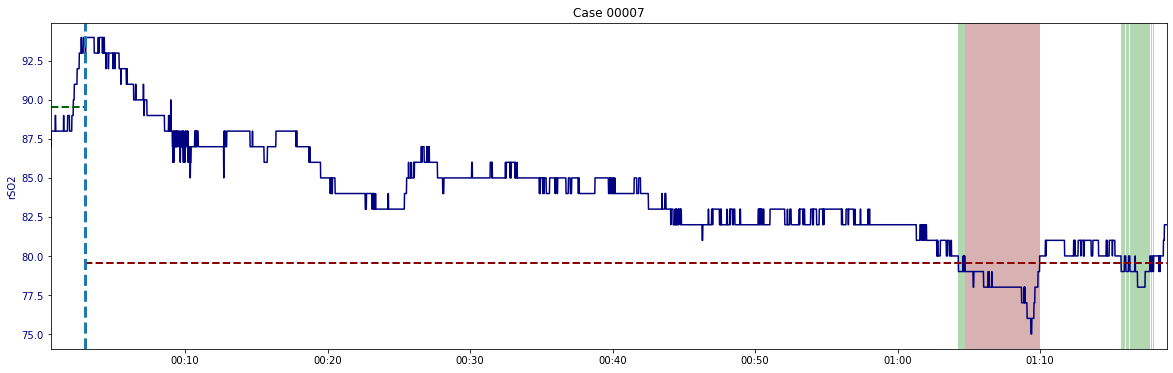

In [336]:
fig, ax = plt.subplots(figsize=(20,6))
ax.set_ylabel('rSO2', color='navy')
ax.plot(df.index, df['rSO2'], color='navy', label='rSO2')
ax.tick_params(axis='y', labelcolor='navy')
plt.title(f'Case {case_str}')
sta = df.index.get_loc(df['rSO2'].first_valid_index())
mrk = (df.index.get_loc(mark_timestamp)-sta) / (df.index.get_loc(end_timestamp)-sta)
ax.axhline(y=baseline, linewidth=2, linestyle='--', xmax=mrk, color='darkgreen', dash_capstyle='butt')
ax.axhline(y=cde_threshold, linewidth=2, linestyle='--', xmin=mrk, color='darkred', dash_capstyle='butt')
ax.axvline(mark_timestamp, linestyle='--', linewidth=3)
for r in cd_ranges:
    ax.axvspan(r[0], r[1], alpha=0.3, color='green', lw=0)
for r in cde_ranges:
    ax.axvspan(r[0], r[1], alpha=0.3, color='maroon', lw=0)
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))
plt.autoscale(enable=True, axis="x", tight=True)

In [337]:
print("Desaturation events found: ", end='')
print(len(cde_ranges))

Desaturation events found: 1


In [338]:
average = df['rSO2'][mark_timestamp:end_timestamp].mean()
ratio = average / baseline
drop = baseline - average

print(f'Baseline rSO2: {baseline:<.2f} %')
print(f'Mean rSO2 after "Mark": {average:<.2f} %')
print(f'Mean/baseline ratio: {average / baseline:<.2f}')
print(f'Mean - baseline: {drop:<.2f} p.p.')

Baseline rSO2: 89.54 %
Mean rSO2 after "Mark": 83.79 %
Mean/baseline ratio: 0.94
Mean - baseline: 5.74 p.p.


### Write to CSV
1 if CDE found, 0 if not

In [339]:
cde = 0
if len(cde_ranges) > 0:
    cde = 1
with open('cde.csv', 'a') as cde_csv:
    cde_csv.write(f'{case_id},{cde},{ratio:<.2f},{drop:<.2f}\n')